# Batch Normalization

<p> Batch normalization is first introduced by Sergey Ioffe and Christian Szegedy, is a simple and effective way to improve the performance of a neural network. In the [paper](http://proceedings.mlr.press/v37/ioffe15.pdf), the authors show that batch normalization enables the use of higher learning rates, acts as a regularizer and speed up the training process. The following is the raw implementation of the concept **batch normalization**

In [34]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [35]:
# Generate predetermined random weights so the network are similarly initialized
w1_initial = np.random.normal(size=(784,100)).astype(np.float32)
w2_initial = np.random.normal(size=(100,100)).astype(np.float32)
w3_initial = np.random.normal(size=(100,10)).astype(np.float32)

# Small epsilon value for the BN transform
epsilon = 1e-3


In [36]:
w1_initial.shape

(784, 100)

#### Building the Graph

In [37]:
# placeholders
x = tf.placeholder(tf.float32, shape=[None, 784])
y_true = tf.placeholder(tf.float32, shape=[None, 10])

In [38]:
# Layer 1 without BN
w1 = tf.Variable(w1_initial)
b1 = tf.Variable(tf.zeros([100]))
z1 = tf.matmul(x,w1)+b1
l1 = tf.nn.sigmoid(z1)

Here is the same layer with BN

In [39]:
z1.get_shape()

TensorShape([Dimension(None), Dimension(100)])

In [40]:
# Layer 1 with BN
w1_bn = tf.Variable(w1_initial)

# Note that pre-batch normalization bias is ommitted. The effect of this bias would be
# eliminated when subtracting the batch mean. Instead, the role of the bias is performed
# by the new beta variable. See Section 3.2 of the BN2015 paper.

z1_bn = tf.matmul(x,w1_bn)

# Calculate batch mean and variance
batch_mean1, batch_var1 = tf.nn.moments(z1_bn, [0])

# Apply initial batch normalizing transform
z1_hat = (z1_bn - batch_mean1)/tf.sqrt(batch_var1 + epsilon)

# Create two new parameters scale (alpha) and beta
scale = tf.Variable(tf.ones([100]))
beta = tf.Variable(tf.zeros([100]))

# Scale and shift to obtain the final output of the batch normalization
# this value is fed into the activation function (here a sigmoid)
bn1 = scale * z1_hat + beta
l1_bn = tf.nn.sigmoid(bn1)

In [41]:
# Layer 2 without BN
w2 = tf.Variable(w2_initial)
b2 = tf.Variable(tf.zeros([100]))
z2 = tf.matmul(l1,w2)+b2
l2 = tf.nn.sigmoid(z2)

Note that tensorflow provides a `tf.nn.batch_normalization`, which is applied to layer2 below. This code does the same thing as the code for layer 1 above.

In [42]:
# Layer 2 with batch normalization, using tensorflows built-in function
w2_bn = tf.Variable(w2_initial)
z2_bn = tf.matmul(l1_bn, w2_bn)
batch_mean2, batch_var2 = tf.nn.moments(z2_bn, [0])
scale2 = tf.Variable(tf.ones([100]))
beta2 = tf.Variable(tf.zeros([100]))
bn2 = tf.nn.batch_normalization(z2_bn,batch_mean2, batch_var2, beta2, scale2, epsilon)
l2_bn = tf.nn.sigmoid(bn2)

In [43]:
# Softmax
w3 = tf.Variable(w3_initial)
b3 = tf.Variable(tf.zeros([10]))
y = tf.nn.softmax(tf.matmul(l2, w3)+b3)

w3_bn = tf.Variable(w3_initial)
b3_bn = tf.Variable(tf.zeros([10]))
y_bn = tf.nn.softmax(tf.matmul(l2_bn, w3_bn)+b3_bn)

In [44]:
# Loss, optimizer and predictions
cross_entropy = -tf.reduce_sum(y_true * tf.log(y))
cross_entropy_bn = -tf.reduce_sum(y_true * tf.log(y_bn))

train_step = tf.train.AdamOptimizer(0.01).minimize(cross_entropy)
train_step_bn = tf.train.AdamOptimizer(0.01).minimize(cross_entropy_bn)

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_true, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
correct_prediction_bn = tf.equal(tf.argmax(y_bn, 1), tf.argmax(y_true, 1))
accuracy_bn = tf.reduce_mean(tf.cast(correct_prediction_bn, tf.float32))

In [45]:
zs, bns, acc, acc_bn = [], [], [], []

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for i in tqdm.tqdm(range(40000)):
    batch = mnist.train.next_batch(50)
    train_step.run(feed_dict={x:batch[0], y_true:batch[1]})
    train_step_bn.run(feed_dict={x:batch[0], y_true:batch[1]})
    
    if i % 50 is 0:
        res = sess.run([accuracy, accuracy_bn, z2, bn2], feed_dict={x: mnist.test.images, y_true: mnist.test.labels})
        acc.append(res[0])
        acc_bn.append(res[1])
        zs.append(np.mean(res[2], axis=0)) # record the mean value of z2 over the entire test set
        bns.append(np.mean(res[3], axis=0))
        
zs, bns, acc, acc_bn = np.asarray(zs), np.asarray(bns), np.asarray(acc), np.asarray(acc_bn)

100%|██████████| 40000/40000 [07:38<00:00, 87.31it/s]


### Plots

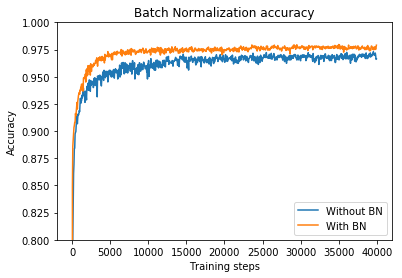

In [46]:
fig, ax = plt.subplots()

ax.plot(range(0, len(acc)*50, 50), acc, label='Without BN')
ax.plot(range(0, len(acc_bn)*50, 50), acc_bn, label='With BN')
ax.set_xlabel('Training steps')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.8, 1])
ax.set_title('Batch Normalization accuracy')
ax.legend(loc=4)
plt.show()

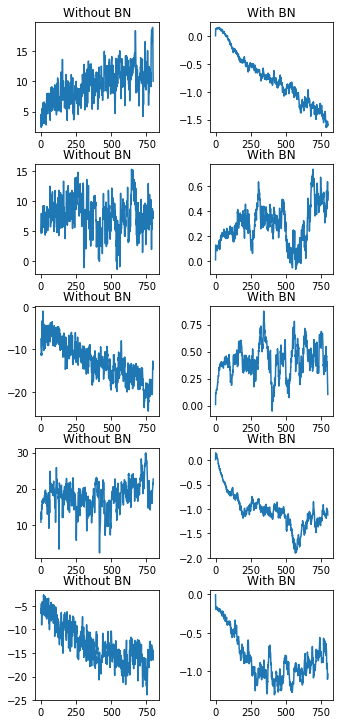

In [47]:
fig, axes = plt.subplots(5, 2, figsize=(5,10))
fig.tight_layout()

for i, ax in enumerate(axes):
    ax[0].set_title('Without BN')
    ax[1].set_title('With BN')
    ax[0].plot(zs[:,i])
    ax[1].plot(bns[:,i])

#### Making predictions with model

In [20]:
predictions = []
correct = 0
for i in range(100):
    pred, corr = sess.run([tf.argmax(y_bn,1), accuracy_bn],
                          feed_dict={x: [mnist.test.images[i]], y_true:[mnist.test.labels[i]]})
    correct += corr
    predictions.append(pred[0])

print("Predictions : ", predictions)
print("Accuracy: ", correct/100)

                          

Predictions :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Accuracy:  0.08


#### Create a batch norm wrapper

In [21]:
def batch_norm_wrapper(inputs, is_training, decay = 0.999):
    
    scale = tf.Variable(tf.ones([inputs.get_shape()[-1]]))
    beta = tf.Variable(tf.zeros([inputs.get_shape()[-1]]))
    pop_mean = tf.Variable(tf.zeros([inputs.get_shape()[-1]]), trainable=False)
    pop_var = tf.Variable(tf.ones([inputs.get_shape()[-1]]), trainable=False)
    
    if is_training:
        batch_mean, batch_var = tf.nn.moments(inputs, [0])
        train_mean = tf.assign(pop_mean, pop_mean * decay + batch_mean * (1-decay))
        train_var = tf.assign(pop_var, pop_var * decay + batch_var * (1-decay))
        
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(inputs, batch_mean, batch_var, beta, scale, epsilon)
    else:
        return tf.nn.batch_normalization(inputs, pop_mean, pop_var, beta, scale, epsilon)

#### Implementation works at test time

In [27]:
def build_graph(is_training):
    #placeholders
    x = tf.placeholder(tf.float32, shape=[None, 784])
    y_ = tf.placeholder(tf.float32, shape=[None, 10])
    
    # Layer 1
    w1 = tf.Variable(w1_initial)
    z1 = tf.matmul(x, w1)
    bn1= batch_norm_wrapper(z1, is_training)
    l1 = tf.nn.relu(bn1)
    
    # Layer 2 
    w2 = tf.Variable(w2_initial)
    z2 = tf.matmul(l1, w2)
    bn2 = batch_norm_wrapper(z2, is_training)
    l2 = tf.nn.relu(bn2)
    
    # Softmax
    w3 = tf.Variable(w3_initial)
    b3 = tf.Variable(tf.zeros([10]))
    y = tf.nn.softmax(tf.matmul(l2, w3))
    
    # Loss, Optimizer and Predictions
    cross_entropy = -tf.reduce_sum(y_ * tf.log(y))
    
    train_step = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cross_entropy)
    
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return (x,y_), train_step, accuracy, y, tf.train.Saver()

In [28]:
# build training graph, train and save the model

sess.close()
tf.reset_default_graph()
(x, y_), train_step, accuracy, _, saver = build_graph(is_training=True)

acc = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in tqdm.tqdm(range(10000)):
        batch = mnist.train.next_batch(60)
        train_step.run(feed_dict={x: batch[0], y_:batch[1]})
        if i % 50 is 0:
            res = sess.run([accuracy], feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            acc.append(res[0])
    saved_model = saver.save(sess, './tmp-bn-save')
    
print("Final accuracy: ", acc[-1])

100%|██████████| 10000/10000 [01:18<00:00, 128.18it/s]


Final accuracy:  0.9589001


#### Lets test

In [30]:
tf.__version__

'1.3.0'

In [32]:
tf.reset_default_graph()

(x,y_), _, accuracy, y, saver = build_graph(is_training=False)
predictions = []
correct = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    new_saver = tf.train.import_meta_graph('tmp-bn-save.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    for i in range(100):
        pred, corr = sess.run([tf.argmax(y,1), accuracy],
                             feed_dict={x: [mnist.test.images[i]], y_: [mnist.test.labels[i]]})
        correct += corr
        predictions.append(pred[0])
print("PREDICTIONS:", predictions)
print("ACCURACY:", correct/100)

INFO:tensorflow:Restoring parameters from ./tmp-bn-save
PREDICTIONS: [7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9]
ACCURACY: 0.99
